In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
#%matplotlib notebook

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

from matplotlib import animation, rc
from IPython.display import HTML

Using TensorFlow backend.


In [2]:
n_nodes = 10
n_dofs = n_nodes*2
n_elements = n_nodes-1
x = np.linspace(0, 1, n_nodes)

In [3]:
L = 1000 #mm
rho = 0.006 #kg/mm
E = 210000 #N/mm2
I = 0.801*10**6 #mm4
A = 764 #mm^2

In [4]:
#Element stiffnes matrix
L = L/n_elements
k = np.matrix([[12, -6*L, -12, -6*L], [-6*L, 4*L**2, 6*L, 2*L**2], [-12, 6*L, 12, 6*L], [-6*L, 2*L**2, 6*L, 4*L**2]])*E*I/L**3

#Element mass matrix
m = np.matrix([[156, 22*L, 54, -13*L],[22*L, 4*L**2, 13*L, -3*L**2], [54, 13*L, 156, -22*L], [-13*L, -3*L**2, -22*L, 4*L**2]] )*rho*A*L/420

In [5]:
#Global stiffness matrix
n_dofs = n_nodes*2
K = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    K[2*i:2*i+4,2*i:2*i+4] += k
    
#Global mass matrix
M = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    M[2*i:2*i+4,2*i:2*i+4] += m
    

In [6]:
#Force vector
F = np.zeros(n_dofs) 
F[-2] = 10000 

In [7]:
#Initial conditions
dz0 = np.zeros(n_nodes)
dzt0 = np.zeros(n_nodes)

d0 = np.zeros(n_dofs)
dt0 = np.zeros(n_dofs)
d0[0:-1:2] = dz0

In [8]:
#Account for homogenous BC
F = F[2:]
K = K[2:,2:]
M = M[2:,2:]

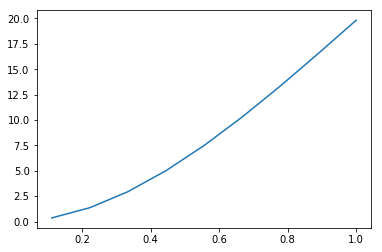

In [9]:
#Static solution

F[-2] = 10000

d = np.matmul(inv(K),F) 

plt.plot(x[1:],d[0::2])

In [10]:
w, v = linalg.eig(K,M)

In [11]:
w_fundamental = np.sqrt(np.real(w.min())) #Lowest eigenfrequency
print(w_fundamental)

0.670653613032


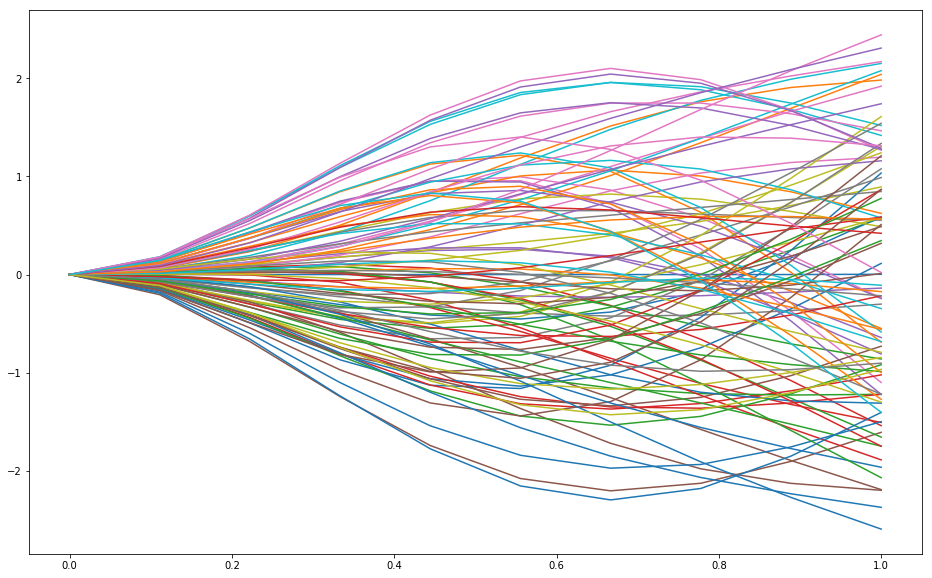

In [12]:
#Timestepping Theta Scheme
Theta = 1/2
d_old = d0[2:]
dt_old = d0[2:]
n_timesteps = 10000
#D = np.zeros([n_nodes, n_timesteps])
#D[:,0] = dz0

dt = 0.01
omega = 0.4

Minv = inv(M)
MinvK = np.matmul(Minv, K)
Q = inv(M + (Theta*dt)**2*K)
P = (M - dt**2*Theta*(1-Theta)*K)
F = np.zeros(n_dofs) 
F = F[2:]
F_new = F

r_end = []
rt_end = []
f = []

plt.figure(figsize=(16,10))

D = np.zeros([n_timesteps, n_nodes])
Dt = np.zeros([n_timesteps, n_nodes])

for i in range(n_timesteps):
    
    #dt_i = -np.matmul(Minv, np.matmul(K,d_i)-F)
    #fi = np.random.random()*np.sin(i*dt)
    #fi = 10000*np.sin(w_fundamental*i*dt*2*np.pi) #~resonance frequency
    fi = 10000*np.cos(omega*i*dt*2*np.pi)
    f.append(fi)
    
    F_old = F_new
    F_new[-2] = fi
    
    
    d_new = np.matmul(Q, np.matmul(P, d_old)) + dt*np.matmul(Q, np.matmul(M,dt_old)) + dt**2*np.matmul(Q, (Theta**2*F_new + Theta*(1-Theta)*F_old))
    
    dt_new = dt_old - dt*np.matmul(MinvK, (Theta*d_new + (1-Theta)*d_old)) + dt*np.matmul(Minv, (Theta*F_new+(1-Theta)*F_old))
    
    dz = d_new[0:-1:2]
    dz = np.insert(dz,0,0)
    dzt = dt_new[0:-1:2]
    dzt = np.insert(dzt,0,0)
    #dz = np.append(dz,0)
    
    r_end.append(dz[-1])
    rt_end.append(dt_new[-2])
    
    d_old = d_new
    dt_old = dt_new
    
    D[i, :] = dz
    Dt[i, :] = dzt
    
    if i%100 == 0:
        plt.plot(x, dz)
    
plt.show()

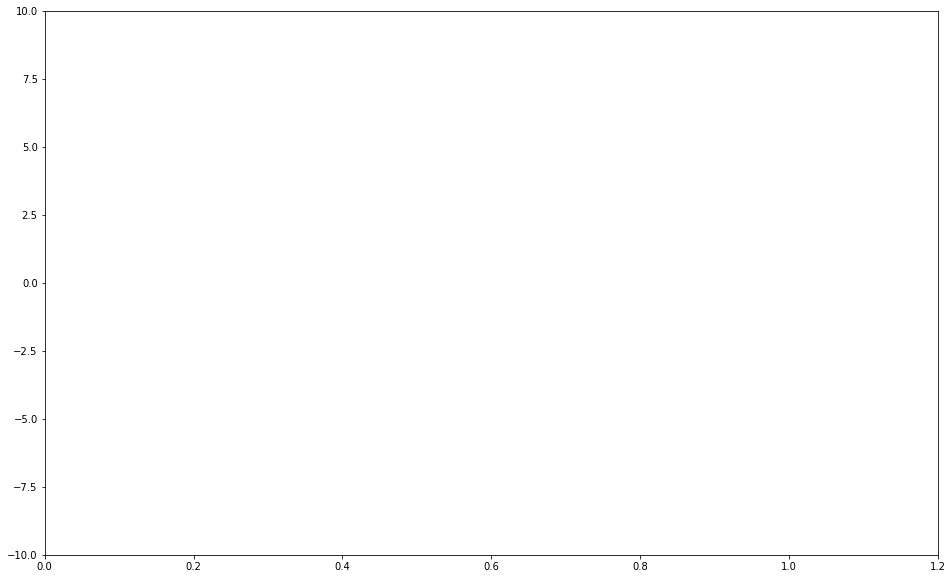

In [13]:


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(16,10))

ax = plt.axes(xlim=(0, 1.2), ylim=(-10, 10))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x_s = x
    y = D[i,:]
    line.set_data(x_s, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)



In [14]:
#HTML(anim.to_jshtml())


In [136]:
#Training data

d = 10 #number of steps in "model memory"
t = d

X_train = np.zeros([n_timesteps-d, d+1+(d*n_nodes)*2])
Y_train = np.zeros([n_timesteps-d, 2*n_nodes])

r_max = max(r_end)
rt_max = max(rt_end)
for i in range(n_timesteps-d):
    X_train[i, 0:d+1] = np.array(f[t-d:t+1])*1/10000
    
    bulk = d+1
    for j in range(n_nodes):
        X_train[i, bulk:bulk + d] = D[t-d:t,j]/r_max
        bulk += d
    
    for j in range(n_nodes):
        X_train[i, bulk: bulk + d] = Dt[t-d:t,j]/rt_max
        bulk += d

    Y_train[i, 0:n_nodes] = D[t, :]/r_max
    Y_train[i, n_nodes:] = Dt[t, :]/rt_max
    t += 1


In [137]:
#Neural network

train_portion = 0.8
input_dim = len(X_train[0,:])
output_dim = len(Y_train[0,:])

x_train = X_train[0:int(n_timesteps*train_portion),:]
x_test = X_train[int(n_timesteps*(train_portion)):,:]
y_train = Y_train[0:int(n_timesteps*train_portion),:]
y_test = Y_train[int(n_timesteps*(train_portion)):,:]

def baseline_model():
    model = Sequential()
    height = 100
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(output_dim, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(x_train, y_train, epochs=100, verbose = 1)

Epoch 1/100
8000/8000 [==============================] - 1s 147us/step - loss: 0.0035
Epoch 2/100
8000/8000 [==============================] - 1s 94us/step - loss: 1.8787e-04
Epoch 3/100
8000/8000 [==============================] - 1s 97us/step - loss: 1.1363e-04
Epoch 4/100
8000/8000 [==============================] - 1s 94us/step - loss: 8.1694e-05
Epoch 5/100
8000/8000 [==============================] - 1s 99us/step - loss: 8.2831e-05
Epoch 6/100
8000/8000 [==============================] - 1s 95us/step - loss: 6.7249e-05
Epoch 7/100
8000/8000 [==============================] - 1s 101us/step - loss: 6.4523e-05 0s - lo
Epoch 8/100
8000/8000 [==============================] - 1s 97us/step - loss: 8.6406e-05
Epoch 9/100
8000/8000 [==============================] - 1s 95us/step - loss: 8.3499e-05
Epoch 10/100
8000/8000 [==============================] - 1s 99us/step - loss: 4.2714e-05
Epoch 11/100
8000/8000 [==============================] - 1s 106us/step - loss: 6.8928e-05
Epoch 12/100

8000/8000 [==============================] - 1s 97us/step - loss: 4.4044e-05
Epoch 92/100
8000/8000 [==============================] - 1s 93us/step - loss: 4.6500e-05
Epoch 93/100
8000/8000 [==============================] - 1s 93us/step - loss: 5.4702e-05
Epoch 94/100
8000/8000 [==============================] - 1s 92us/step - loss: 4.3518e-05
Epoch 95/100
8000/8000 [==============================] - 1s 93us/step - loss: 6.1402e-05
Epoch 96/100
8000/8000 [==============================] - 1s 94us/step - loss: 5.0177e-05
Epoch 97/100
8000/8000 [==============================] - 1s 95us/step - loss: 4.1282e-05
Epoch 98/100
8000/8000 [==============================] - 1s 93us/step - loss: 5.1515e-05
Epoch 99/100
8000/8000 [==============================] - 1s 94us/step - loss: 4.1299e-05
Epoch 100/100
8000/8000 [==============================] - 1s 92us/step - loss: 3.6769e-05


In [138]:
predictions = model.predict(x_test)

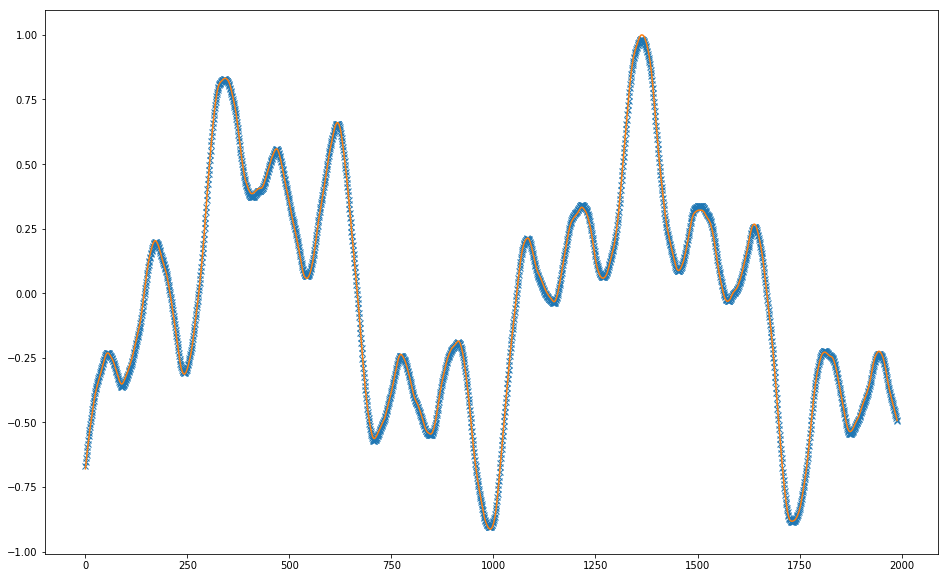

In [139]:
plt.figure(figsize=(16,10))
plt.plot(predictions[:,n_nodes-1], 'x')
plt.plot(y_test[:, n_nodes-1])
plt.show()

In [140]:
#Errorfunction
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [141]:
#Error
print(rmse(predictions[:,n_nodes-1], y_test[:,n_nodes-1]))

0.00846805116567


In [142]:
#Errorplot
#plt.plot(np.sqrt((y_test[:, ]-predictions[:,0])**2))

In [143]:
#independent prediction

input_i = np.copy(x_test[0,:])
print(input_i)

dz = np.copy(input_i[d+1:d+1+n_nodes*d])

dz = np.reshape(dz, (d, n_nodes))
print(dz)

dzt = np.copy(input_i[d+1+n_nodes*d:])
dzt = np.reshape(dzt, (n_nodes, d))

preds = np.zeros([len(x_test[:,0])-1, n_nodes*2])
force = np.copy(x_test[:, 0:d+1])

for i in range(len(x_test[:,0])-1):
    
    
    pred = model.predict(np.reshape(input_i,(1,len(input_i))))
    preds[i, :] = pred
    
    input_i[0:d+1] = force[i+1,:]
    
    dz = np.delete(dz, 0, 1)
    dz = np.concatenate((dz, np.reshape(pred[0,0:n_nodes], (1,n_nodes)).T), axis=1)
    dz[0,:] = np.zeros(n_nodes)
    dzt = np.delete(dzt, 0, 1)
    dzt = np.concatenate((dzt, np.reshape(pred[0,n_nodes:], (1, n_nodes)).T), axis=1)
    dzt[0,:] = np.zeros(n_nodes)
    input_i[d+1:d+1+n_nodes*d] = np.reshape(dz, (1, n_nodes*d))[0]
    input_i[d+1+n_nodes*d:] = np.reshape(dzt, (1, n_nodes*d))[0]
    
    if i == 5:
        print(dz)
        print(input_i)
    

[ 1.          0.99968419  0.99873696  0.9971589   0.99495102  0.9921147
  0.98865174  0.98456433  0.97985505  0.97452687  0.96858316  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.         -0.04136768 -0.04227028 -0.04311322 -0.04381849 -0.04441808
 -0.04496869 -0.04559155 -0.04638811 -0.04738562 -0.04849948 -0.14499776
 -0.14755768 -0.15003767 -0.15256734 -0.1550873  -0.1575957  -0.16013255
 -0.16258498 -0.16490459 -0.16709849 -0.28044187 -0.28530895 -0.29005712
 -0.29472797 -0.29930616 -0.30375016 -0.30791707 -0.31168908 -0.31506098
 -0.31804997 -0.42152906 -0.4283165  -0.43485751 -0.44096737 -0.44662416
 -0.45185931 -0.45670406 -0.46133606 -0.46583285 -0.47017648 -0.54865535
 -0.55540502 -0.56180718 -0.56788195 -0.57369637 -0.57928572 -0.58470624
 -0.59005475 -0.59534509 -0.60066546 -0.65042655 -0.65536411 -0.66014797
 -0.66488008 -0.66964445 -0.67443808 -0.67922861 -0.68390087 -0.68828164
 -0.69233929 -0.72695169 -0.72823978 -0.7296

In [144]:
y_test[0:15,1]

array([-0.04957246, -0.0504416 , -0.0509864 , -0.05119253, -0.0510757 ,
       -0.05069957, -0.05017953, -0.04965069, -0.0492601 , -0.04910051,
       -0.04925088, -0.04970378, -0.05040202, -0.05128066, -0.05221394])

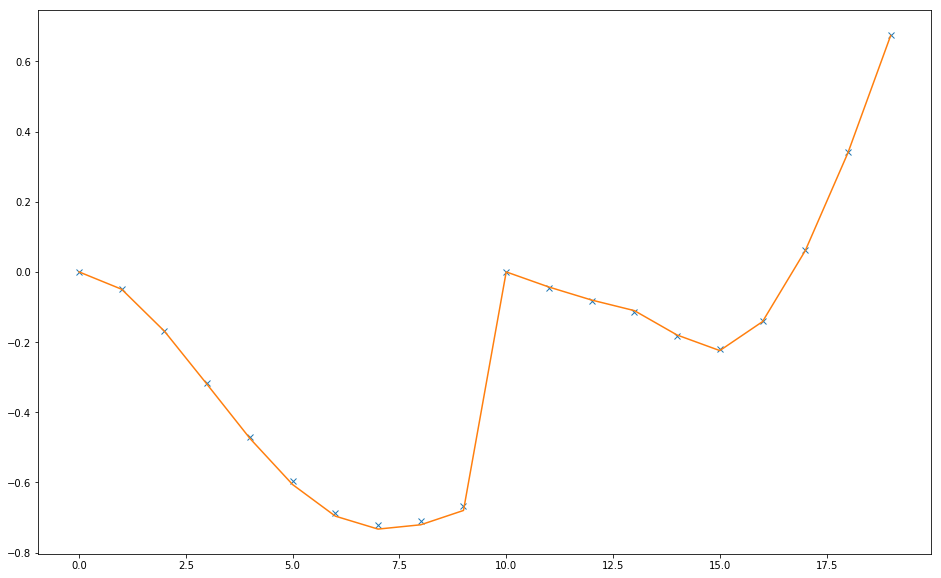

In [145]:
input_i = np.copy(x_test[0,:])

dz = np.copy(input_i[d+1:d+1+n_nodes*d])

dz = np.reshape(dz, (d, n_nodes))
pred = model.predict(np.reshape(input_i,(1,len(input_i))))

plt.figure(figsize=(16,10))
plt.plot(pred[0], 'x')
plt.plot(y_test[0, :])
plt.show()

In [146]:

dz

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.04136768, -0.04227028, -0.04311322, -0.04381849, -0.04441808,
        -0.04496869, -0.04559155, -0.04638811, -0.04738562, -0.04849948],
       [-0.14499776, -0.14755768, -0.15003767, -0.15256734, -0.1550873 ,
        -0.1575957 , -0.16013255, -0.16258498, -0.16490459, -0.16709849],
       [-0.28044187, -0.28530895, -0.29005712, -0.29472797, -0.29930616,
        -0.30375016, -0.30791707, -0.31168908, -0.31506098, -0.31804997],
       [-0.42152906, -0.4283165 , -0.43485751, -0.44096737, -0.44662416,
        -0.45185931, -0.45670406, -0.46133606, -0.46583285, -0.47017648],
       [-0.54865535, -0.55540502, -0.56180718, -0.56788195, -0.57369637,
        -0.57928572, -0.58470624, -0.59005475, -0.59534509, -0.60066546],
       [-0.65042655, -0.65536411, -0.66014797, -0.66488008, -0.66964445,
        -0.67443808, -0.67922861, -0.68390087

In [147]:
pred

array([[ -2.30436475e-04,  -4.84900773e-02,  -1.67457610e-01,
         -3.17536980e-01,  -4.69034702e-01,  -5.97130656e-01,
         -6.85957015e-01,  -7.22382545e-01,  -7.10233390e-01,
         -6.68257773e-01,  -8.93873279e-04,  -4.60098349e-02,
         -8.25996101e-02,  -1.13594189e-01,  -1.82685778e-01,
         -2.19746500e-01,  -1.38986200e-01,   6.27466887e-02,
          3.40313524e-01,   6.75281405e-01]], dtype=float32)

In [148]:
y_test[0, :]

array([ 0.        , -0.04957246, -0.16910224, -0.32075024, -0.47443247,
       -0.60599613, -0.69596178, -0.73285589, -0.72054878, -0.67976345,
        0.        , -0.04310236, -0.08021569, -0.11034345, -0.1798208 ,
       -0.22422944, -0.14172939,  0.06032021,  0.33939822,  0.67342785])

In [149]:
print(pred[0][9])
print(y_test[0,9])


-0.668258
-0.679763452787


In [150]:
np.reshape(pred[0,0:n_nodes], (1,n_nodes))

array([[ -2.30436475e-04,  -4.84900773e-02,  -1.67457610e-01,
         -3.17536980e-01,  -4.69034702e-01,  -5.97130656e-01,
         -6.85957015e-01,  -7.22382545e-01,  -7.10233390e-01,
         -6.68257773e-01]], dtype=float32)

In [151]:
np.reshape(pred[0,0:n_nodes], (1,n_nodes))

array([[ -2.30436475e-04,  -4.84900773e-02,  -1.67457610e-01,
         -3.17536980e-01,  -4.69034702e-01,  -5.97130656e-01,
         -6.85957015e-01,  -7.22382545e-01,  -7.10233390e-01,
         -6.68257773e-01]], dtype=float32)

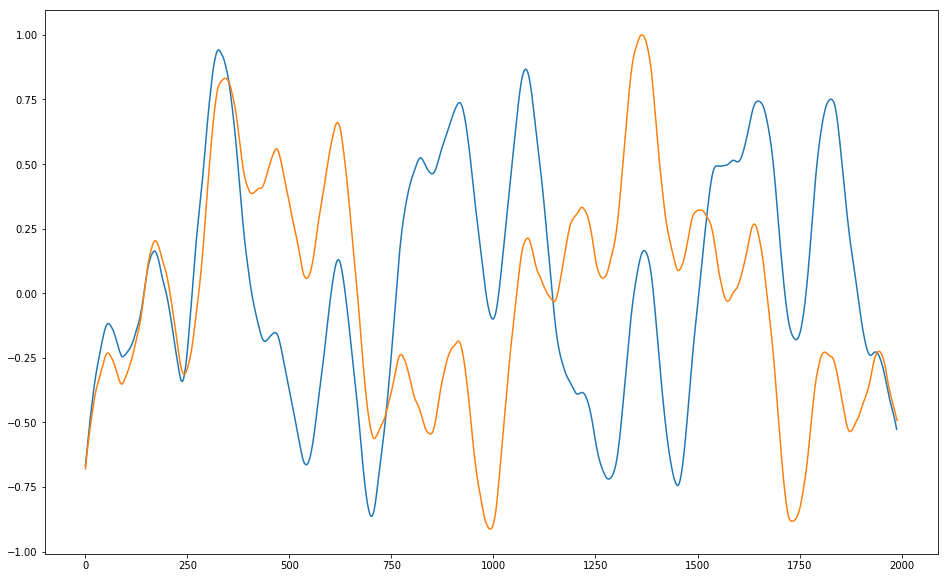

In [152]:
plt.figure(figsize=(16,10))
plt.plot(preds[:,n_nodes-1], '-')
plt.plot(y_test[:, n_nodes-1])
plt.show()

In [511]:
y_test[0,:]

array([ 0.        , -0.04136768, -0.14499776, -0.28044187, -0.42152906,
       -0.54865535, -0.65042655, -0.72695169, -0.78530082, -0.8338269 ,
        0.        , -0.03741765, -0.11282914, -0.21030726, -0.29126634,
       -0.2942312 , -0.21399022, -0.05331935,  0.21073668,  0.55188966])

In [422]:
print(rmse(preds, y_test[0,:len(preds)]))

0.381511471032


In [ ]:
#Errorplot
plt.plot(np.sqrt((y_test[0,:len(preds)]-preds)**2))

In [267]:
def get_training_data(p, omega, dt, d, cycles):

    #Timestepping Theta Scheme
    Theta = 1/2
    d_old = d0[2:]
    dt_old = d0[2:]
    
    
    #_timesteps = int(cycles/(omega*dt))
    #D = np.zeros([n_nodes, n_timesteps])
    #D[:,0] = dz0
    n_timesteps = 10000
    
    Minv = inv(M)
    MinvK = np.matmul(Minv, K)
    Q = inv(M + (Theta*dt)**2*K)
    P = (M - dt**2*Theta*(1-Theta)*K)
    F = np.zeros(n_dofs) 
    F = F[2:]
    F_new = F

    r_end = []
    rt_end = []
    f = []

    D = np.zeros([n_timesteps, n_nodes])

    for i in range(n_timesteps):

        #dt_i = -np.matmul(Minv, np.matmul(K,d_i)-F)
        #fi = np.random.random()*np.sin(i*dt)
        #fi = 10000*np.sin(w_fundamental*i*dt*2*np.pi) #~resonance frequency
        
        fi = p*np.sin(omega*i*dt*2*np.pi)
        f.append(fi)

        F_old = F_new
        F_new[-2] = fi


        d_new = np.matmul(Q, np.matmul(P, d_old)) + dt*np.matmul(Q, np.matmul(M,dt_old)) + dt**2*np.matmul(Q, (Theta**2*F_new + Theta*(1-Theta)*F_old))

        dt_new = dt_old - dt*np.matmul(MinvK, (Theta*d_new + (1-Theta)*d_old)) + dt*np.matmul(Minv, (Theta*F_new+(1-Theta)*F_old))

        dz = d_new[0:-1:2]
        dz = np.insert(dz,0,0)
        #dz = np.append(dz,0)

        r_end.append(dz[-1])
        rt_end.append(dt_new[-2])

        d_old = d_new
        dt_old = dt_new

        D[i, :] = dz
        
        #f i % 1000== 0:
        #   p =np.random.random()*10000
        #   omega = np.random.random()*0.01


    d = 10 #number of steps in "model memory"
    t = d

    X_train = np.zeros([n_timesteps-d, d*3+1])
    Y_train = np.zeros([n_timesteps-d, 2])

    #_max = max(abs(np.array(f)))
    #_max = max(abs(np.array(r_end)))
    #t_max = max(abs(np.array(rt_end)))
    for i in range(n_timesteps-d):
        X_train[i,0:d+1] = np.array(f[t-d:t+1])#f_max
        X_train[i,d+1:2*d+1] = r_end[t-d:t]#r_max
        X_train[i,(2*d+1):] = np.array(rt_end[t-d:t])#rt_max

        Y_train[i, :] = [r_end[t], rt_end[t]]
        t += 1


    train_portion = 0.8
    input_dim = len(X_train[:,0])

    x_train = X_train[0:int(n_timesteps*train_portion), :]
    x_test = X_train[int(n_timesteps*(train_portion)):, :]
    y_train = Y_train[0:int(n_timesteps*train_portion), :]
    y_test = Y_train[int(n_timesteps*(train_portion)):, :]


    return x_train, x_test, y_train, y_test

In [268]:

omegas = [0.01] #[0.001, 0.002, 0.005, 0.01, 0.05] #0.2, 0.5, 1, 2, 5]
forces = [10000] #,2000,5000,10000,20000,50000]

counter = 0
f=10000
for p in forces:
    
    for omega in omegas:

        x_train, x_test, y_train, y_test = get_training_data(f, omega, 1, 10, 50)

        if counter == 0:
            X_train = x_train
            Y_train = y_train
            X_test = x_test
            Y_test = y_test

        else:

            X_train = np.concatenate((X_train, x_train), axis=0)
            Y_train = np.concatenate((Y_train, y_train), axis=0)
            X_test = np.concatenate((X_test, x_test), axis=0)
            Y_test = np.concatenate((Y_test, y_test), axis=0)
        
        #if counter % 1000 == 0:
        #    f = np.random.random()*10000

        counter += 1

r_max = max(abs(Y_train[0,:]))
rt_max = max(abs(Y_train[1,:]))
f_max = 10000

X_train[:,0:d+1] = X_train[:,0:d+1]/f_max
X_test[:,0:d+1] = X_test[:,0:d+1]/f_max

X_train[:, d+1:2*d+1] = X_train[:, d+1:2*d+1]/r_max
X_test[:, d+1:2*d+1] = X_test[:, d+1:2*d+1]/r_max
Y_train[:,0] = Y_train[:,0]/r_max
Y_test[:,0] = Y_test[:,0]/r_max

X_train[:,2*d+1:] = X_train[:,2*d+1:]/rt_max
X_test[:,2*d+1:] = X_test[:, 2*d+1:]/rt_max
Y_train[:,1] = Y_train[:,1]/rt_max
Y_test[:,1] = Y_test[:,1]/rt_max

In [265]:
max(Y_test[:,0]/r_max)

0.17068918972664318

In [269]:
#Neural network

input_dim = len(X_train[0,:])


def baseline_model():
    model = Sequential()
    height = 50
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(2, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(X_train, Y_train, epochs=100, verbose = 1)

Epoch 1/100
8000/8000 [==============================] - 2s 225us/step - loss: 0.0556
Epoch 2/100
8000/8000 [==============================] - 1s 73us/step - loss: 0.0015
Epoch 3/100
8000/8000 [==============================] - 1s 67us/step - loss: 7.6232e-04
Epoch 4/100
8000/8000 [==============================] - 1s 73us/step - loss: 3.9031e-04: 0s - loss:
Epoch 5/100
8000/8000 [==============================] - 1s 66us/step - loss: 2.3529e-04
Epoch 6/100
8000/8000 [==============================] - 0s 62us/step - loss: 1.0828e-04
Epoch 7/100
8000/8000 [==============================] - 1s 64us/step - loss: 7.0282e-05
Epoch 8/100
8000/8000 [==============================] - 1s 71us/step - loss: 6.9082e-05
Epoch 9/100
8000/8000 [==============================] - 0s 60us/step - loss: 5.1274e-05
Epoch 10/100
8000/8000 [==============================] - 1s 68us/step - loss: 5.9014e-05
Epoch 11/100
8000/8000 [==============================] - 1s 74us/step - loss: 4.4741e-05
Epoch 12/100
8

In [270]:
predictions = model.predict(X_test)

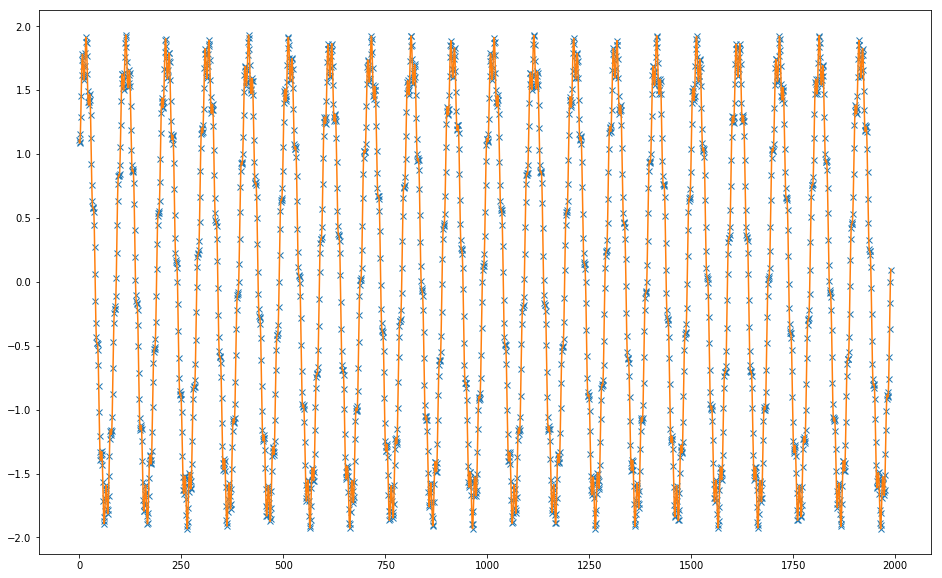

In [272]:
plt.figure(figsize=(16,10))
plt.plot(predictions[:,0], 'x')
plt.plot(Y_test[:,0])
plt.show()

In [273]:
print(rmse(predictions[:,0], Y_test[:,0]))

0.00215219720216


In [274]:
#independent prediction

input_i = np.copy(X_test[0,:])
r = input_i[d+1:2*d+1]
rt = input_i[2*d+1:]

preds = []
force = np.copy(X_test[:, 0:d+1])
for i in range(1000):
    
    
    pred = model.predict(np.reshape(input_i,(1,len(input_i))))
    preds.append(pred[0][0])
    
    input_i[0:d+1] = force[i+1, :]
    
    r = np.delete(r, 0)
    r = np.append(r, pred[0][0])
    rt = np.delete(rt, 0)
    rt = np.append(rt, pred[0][1])
    input_i[d+1:2*d+1] = r
    input_i[2*d+1:] = rt
    

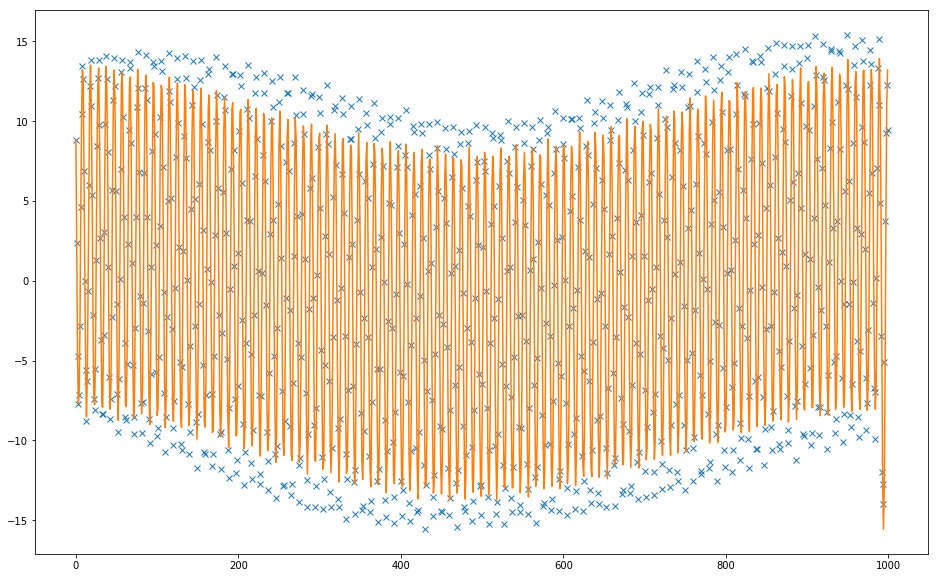

In [254]:
plt.figure(figsize=(16,10))
plt.plot(preds[:], 'x')
plt.plot(Y_test[:len(preds),0])
plt.show()

In [236]:
print(rmse(preds, Y_test[:len(preds),0]))

0.0290114976352


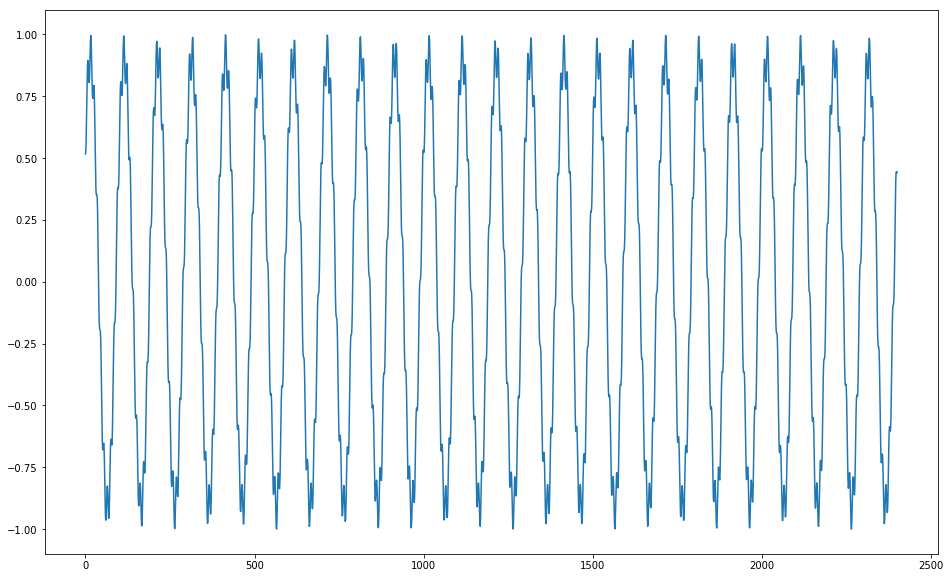

In [152]:
plt.figure(figsize=(16,10))
plt.plot(Y_train[:,0])